# Showalter EXT table

Whats this notebook about?

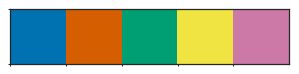

In [1]:
import sys
import os
from glob import glob
import re
from random import shuffle
import itertools as it
from operator import methodcaller, itemgetter
from bisect import bisect_left

import requests
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from IPython.display import Image, HTML, display, clear_output
import networkx as nx
from networkx.algorithms import clique

from fake_useragent import FakeUserAgent
from pysam import FastaFile

## Default plotting params

%matplotlib inline
pd.options.display.max_rows = 100
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [2]:
url = 'http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2879790/table/tbl5/?report=objectonly'
headers = {'User-Agent': FakeUserAgent().random}
html = requests.get(url, headers=headers)

In [3]:
ext_table_, = pd.read_html(html.text)
ext_table_.head()

,Locus Identifiera,Nameb,Class,SP3/SP4/SP5/YXY Repeats,Amino Acids,SPc,GPI,Organ-Specific Expression,Introns,P/5/E/I/3 Mutantsd,Top Five BLAST Hit HRGPse
0,At1g26240,EXT20,SP5,2/1/40/44,478,Yes,No,Roots,0,1/3/2/0/0,"EXT17, EXT21, EXT22, LRX5, EXT1/4"
1,At1g26250,EXT21,SP5,7/0/28/40,443,Yes,No,Roots,0,1/0/5/0/3,"EXT1/4, EXT17, EXT20, EXT22, LRX5"
2,At4g08370,EXT22,SP5,3/1/13/18,350,Yes,No,NaN,2,1/0/0/0/0,"EXT20, EXT21, EXT17, LRX1, EXT7"
3,At4g13390,EXT18,SP5/SP4,0/14/8/13,429,Yes,No,Roots,0,4/0/2/0/0,"EXT11, EXT12, EXT13, EXT14, EXT15"
4,At5g19810,EXT19,SP5/SP4,0/4/13/1,249,Yes,No,Roots,0,7/0/1/0/1,"EXT39, EXT35, EXT40, AGP9C"


In [4]:
ext_table = ext_table_.iloc[:, [0, 1, 2, 3, 7]].copy()
ext_table.columns = [
    'agi_id', 'gene_symbol',
    'class', 'repeats',
    'expression_tissue'
]
ext_table['agi_id'] = ext_table.agi_id.str.upper()
ext_table.loc[ext_table.expression_tissue == 'nr', 'expression_tissue'] = np.nan
ext_table.loc[ext_table.expression_tissue == 'nrf', 'expression_tissue'] = np.nan
ext_table.set_index('agi_id', inplace=True)
ext_table[['sp3_motif', 'sp4_motif', 'sp5_motif', 'yxy_motif']] = (
    ext_table.pop('repeats').str.split('/', expand=True).astype('i')
)
ext_table.head()

,gene_symbol,class,expression_tissue,sp3_motif,sp4_motif,sp5_motif,yxy_motif
agi_id,,,,,,,
AT1G26240,EXT20,SP5,Roots,2,1,40,44
AT1G26250,EXT21,SP5,Roots,7,0,28,40
AT4G08370,EXT22,SP5,NaN,3,1,13,18
AT4G13390,EXT18,SP5/SP4,Roots,0,14,8,13
AT5G19810,EXT19,SP5/SP4,Roots,0,4,13,1


In [5]:
%%bash
source activate cgat_python2

cgat gtf2gtf --method=merge-transcripts --filter=proteincoding \
  -I /home/matthew/Documents/genomes/tair10/gff/Araport11_GFF3_genes_transposons.201606.gtf \
  -L /dev/null | \
awk -v OFS='\t' '{print $1, $4 - 1, $5, $10, ".", $7}' | sed 's/[";]//g' > araport11_genes.bed

In [6]:
fasta = FastaFile('/home/matthew/Documents/genomes/tair10/fasta/tair10_genome.fa')

genes = pd.read_table('araport11_genes.bed',
                      sep='\t',
                      usecols=[0, 1, 2, 3, 5],
                      names=['chrom', 'start', 'end', 'gene_id', 'strand'],
                      index_col='gene_id')
ext_table = ext_table.join(genes, how='left')
ext_table.head()

,gene_symbol,class,expression_tissue,sp3_motif,sp4_motif,sp5_motif,yxy_motif,chrom,start,end,strand
agi_id,,,,,,,,,,,
AT1G26240,EXT20,SP5,Roots,2,1,40,44,1,9077873,9079646,-
AT1G26250,EXT21,SP5,Roots,7,0,28,40,1,9083837,9085464,+
AT4G08370,EXT22,SP5,NaN,3,1,13,18,4,5301961,5303314,-
AT4G13390,EXT18,SP5/SP4,Roots,0,14,8,13,4,7783790,7785366,+
AT5G19810,EXT19,SP5/SP4,Roots,0,4,13,1,5,6692908,6694058,+


In [7]:
def build_g_run_graph(seq, max_loop_length=7, rc=False):
    graph = nx.Graph()
    regex = '(?=CC)' if rc == False else '(?=GG)'
    g_runs = map(methodcaller('start'), re.finditer(regex, seq))
    for g1, g2 in it.combinations(g_runs, r=2):
        dist = (g2 - (g1 + 2))
        if dist <= max_loop_length:
            graph.add_edge(g1, g2, dist=dist)
    return graph


def enumerate_subgraphs(g, k):
    for sg in nx.connected_components(g):
        if len(sg) >= k:
            for v in sg:
                v_ext = [u for u in g.neighbors(v) if v < u]
                yield from extend_subgraph(g, [v], v_ext, k, 0)


def extend_subgraph(g, v_sg, v_ext, k, i):
    if len(v_sg) == k:
        yield v_sg
        return
    j = 0
    while len(v_ext) != 0:
        w = v_ext.pop(0)
        v_ext_ = [u for u in g.neighbors(w)
                 if u not in v_sg and u > w]
        yield from extend_subgraph(g, v_sg + [w, ], v_ext_, k, i + 1)


def subgraph_to_range(subgraph_iter):
    for sg in subgraph_iter:
        yield sg[0], sg[-1] + 2


def check_overlapping(cluster_range, record_start):
    '''
    check if record y overlaps with cluster range x
    '''
    if record_start < cluster_range[1]:
        return True
    else:
        return False


def cluster_overlapping(record_iter):
    '''
    generator yielding new clusters, treats each strand separately
    '''
    record_iter = iter(record_iter)
    cluster = []
    cluster_range = [0, 0]
    while True:
        try:
            record = next(record_iter)
        except StopIteration:
            if cluster:
                yield cluster
            break

        # check cluster not empty:
        if not cluster:
            cluster.append(record)
            cluster_range = list(record)

        # check if record overlaps with cluster
        elif check_overlapping(cluster_range, record[0]):
            cluster.append(record)

            # if neccessary, increase cluster range
            if record[1] > cluster_range[1]:
                cluster_range[1] = record[1]

        # if record does not overlap with cluster, yield the cluster
        # and start a new one
        else:
            yield cluster
            cluster = [record, ]
            cluster_range = list(record)


def filter_overlapping(cluster):
    '''
    find the non-overlapping records in a cluster which yield
    the best total score.
    '''
    # if cluster is only one record, return it
    if len(cluster) == 1:
        yield cluster[0]
        return
    # if cluster is only two records, return shorter loops
    if len(cluster) == 2:
        yield min(cluster, key=lambda x: x[1] - x[0])
        return
    # cluster is sorted by stop-values
    end_sorted_cluster = sorted(cluster, key=itemgetter(1))
    end_sorted_vals = [x[1] for x in end_sorted_cluster]

    # vector of maximum scores, one longer than cluster size
    max_of_cluster = [[0, 0, 0], ] * (len(cluster) + 1)

    # calculate max score from cluster:
    # for each record in the cluster:
    for i, record in enumerate(end_sorted_cluster):

        # calculate the score from prev records if not including this record
        not_incl = max(max_of_cluster[i][:2])

        # find the closest non-overlapping record left of the current one
        closest = bisect_left(end_sorted_vals, record[1])
        if closest == 0:
            closest = -1

        # score including this record is total from closest plus current
        incl = max(max_of_cluster[closest][:2]) + (30 - (record[1] - record[0]))

        # store scores and closest record in matrix
        max_of_cluster[i + 1] = [not_incl, incl, closest]
    # backtrack through matrix to get high scoring records:
    i = len(cluster)
    incl_records = []
    while i != -1:
        # if not_incl score is less than incl
        if max_of_cluster[i][1] >= max_of_cluster[i][0]:

            # include cluster[i]
            incl_records.append(end_sorted_cluster[i - 1])

            # jump to closest
            i = max_of_cluster[i][2]
        else:

            # try next record
            i -= 1

    for record in incl_records:
        yield record


def cluster_and_filter(record_iter):
    for cluster in cluster_overlapping(record_iter):
        yield from filter_overlapping(cluster)

In [8]:
gene_length = []
overlapping_g4 = []
filtered_g4 = []
merged_g4 = []
for gene, chrom, start, end, strand in ext_table[['chrom', 'start', 'end', 'strand']].itertuples():
    seq = fasta.fetch(str(chrom), start, end).upper()
    gene_length.append(len(seq))
    g = build_g_run_graph(seq, max_loop_length=7, rc=(strand == '-'))
    o = list(enumerate_subgraphs(g, 4))
    f = list(cluster_and_filter(sorted(subgraph_to_range(o), key=itemgetter(0))))
    m = [x for x in nx.connected_components(g) if len(x) >= 4]
    overlapping_g4.append(len(o))
    filtered_g4.append(len(f))
    merged_g4.append(len(m))
ext_table['gene_length'] = gene_length
ext_table['overlapping_pg4'] = overlapping_g4
ext_table['filtered_pg4'] = filtered_g4
ext_table['merged_pg4'] = merged_g4

In [9]:
nmm_vs_cntrl = pd.read_csv(
    '../tair10_nmm_rnaseq/nmm_rnaseq_differential_expression_05022018.tsv',
    sep='\t', index_col=0, usecols=[0, 1, 2, 5])
nmm_vs_cntrl.head()

,logFC,logCPM,FDR
AT1G01010,0.848345,5.679371,7.723917e-20
AT1G01020,-0.112609,4.284573,3.226948e-01
AT1G01030,-0.148465,1.414800,4.668409e-01
AT1G01040,0.170917,5.911781,5.303067e-02
AT1G01050,-0.462401,6.045595,3.281001e-08


In [10]:
ext_table_nmm = ext_table.join(nmm_vs_cntrl, how='left')
ext_table_nmm.head()

,gene_symbol,class,expression_tissue,sp3_motif,sp4_motif,sp5_motif,yxy_motif,chrom,start,end,strand,gene_length,overlapping_pg4,filtered_pg4,merged_pg4,logFC,logCPM,FDR
agi_id,,,,,,,,,,,,,,,,,,
AT1G26240,EXT20,SP5,Roots,2,1,40,44,1,9077873,9079646,-,1773,440,102,44,3.721471,6.802750,1.096868e-168
AT1G26250,EXT21,SP5,Roots,7,0,28,40,1,9083837,9085464,+,1627,480,92,38,-3.403088,5.565503,5.061161e-10
AT4G08370,EXT22,SP5,NaN,3,1,13,18,4,5301961,5303314,-,1353,441,70,25,NaN,NaN,NaN
AT4G13390,EXT18,SP5/SP4,Roots,0,14,8,13,4,7783790,7785366,+,1576,634,68,31,-2.627889,5.474627,8.447693e-28
AT5G19810,EXT19,SP5/SP4,Roots,0,4,13,1,5,6692908,6694058,+,1150,466,70,21,NaN,NaN,NaN


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Background RRGGBBAA: ffffff00
Area 0:0:1280:1942.5 exported to 1280 x 1943 pixels (90 dpi)
Bitmap saved as: ext_showalter_table.png


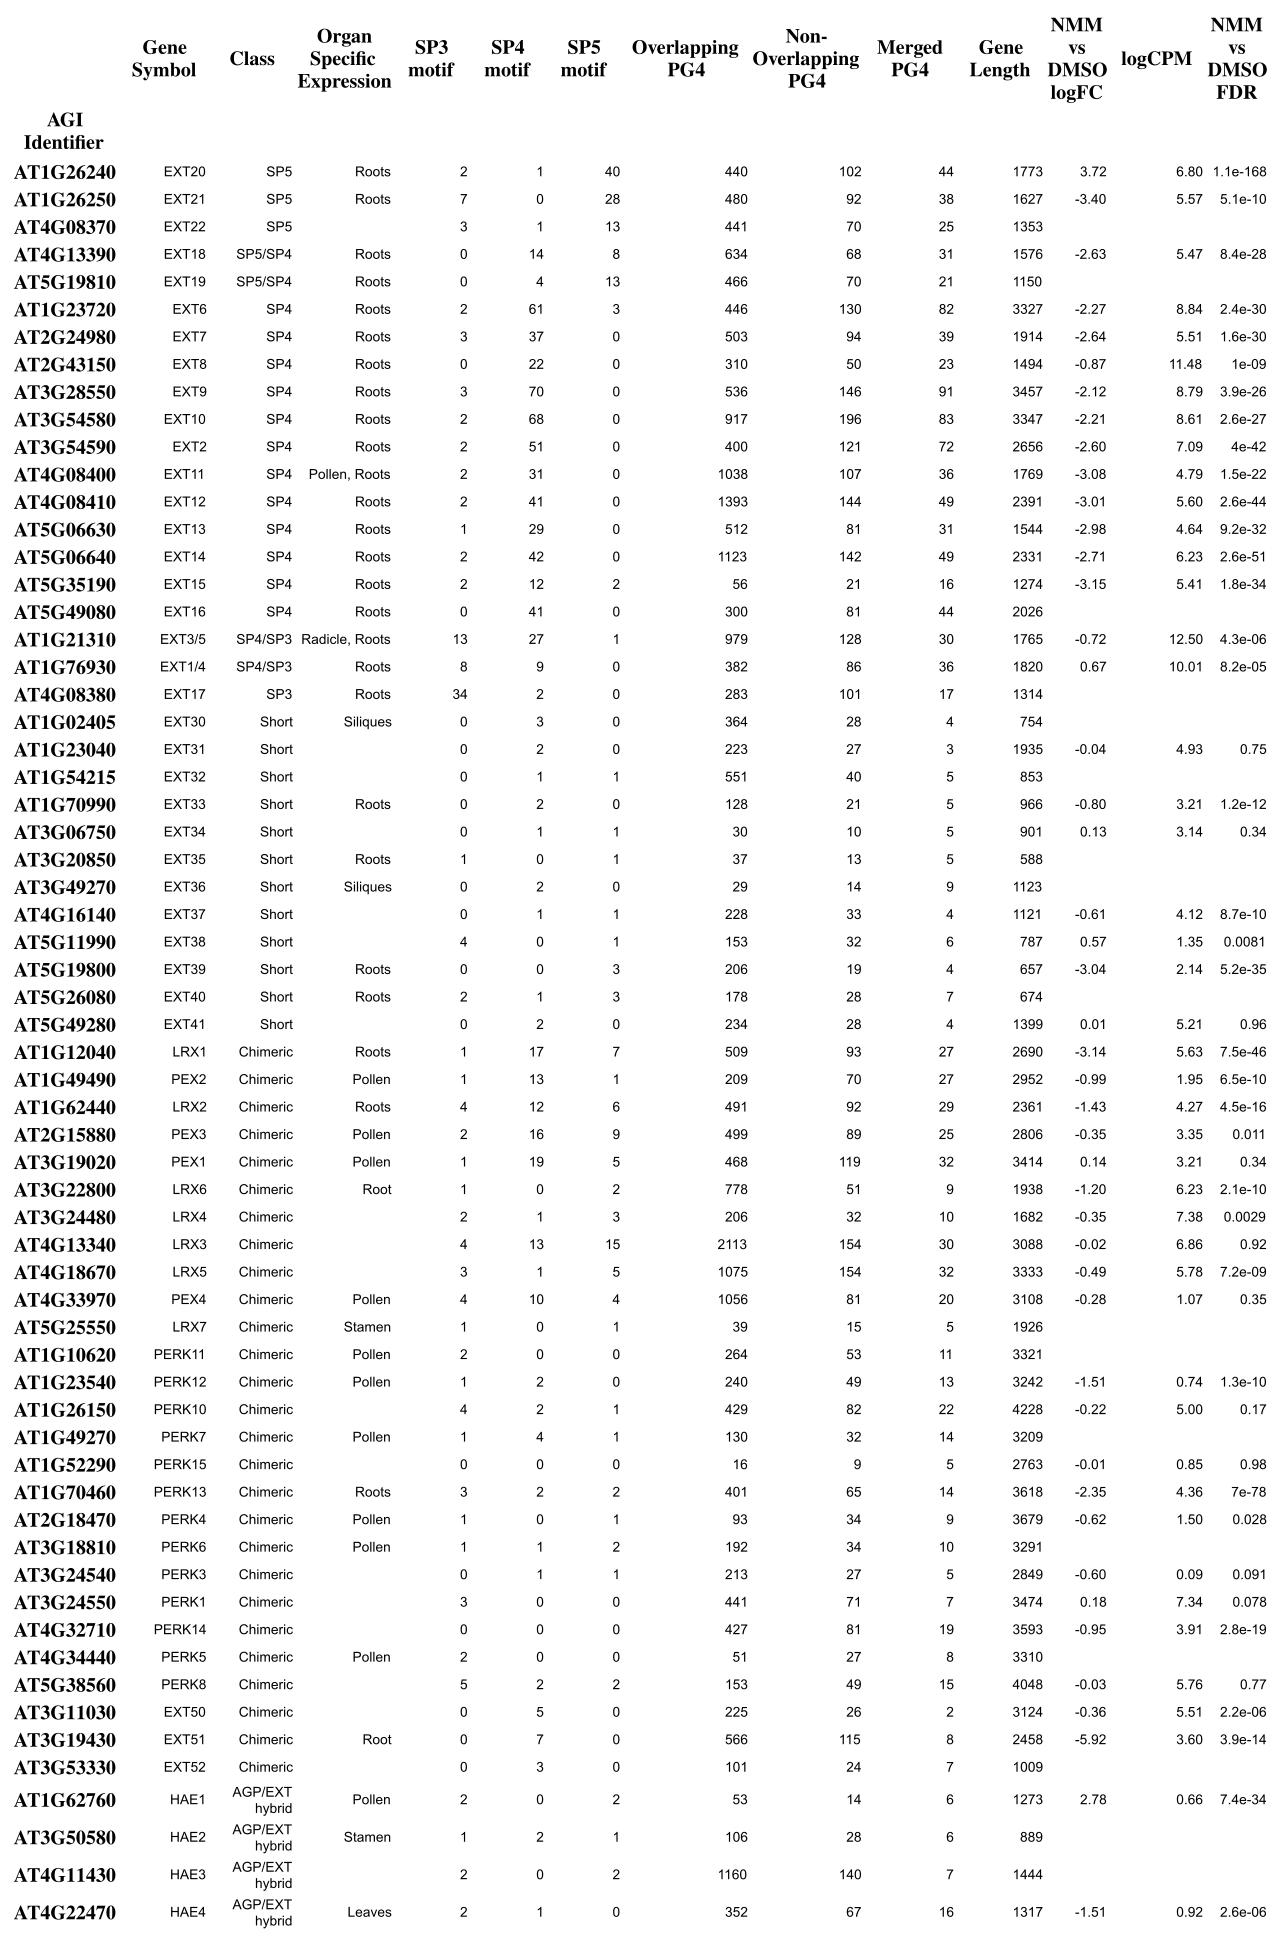

In [11]:
table = ext_table_nmm[
    ['gene_symbol', 'class', 'expression_tissue',
     'sp3_motif', 'sp4_motif', 'sp5_motif',
     'overlapping_pg4', 'filtered_pg4', 'merged_pg4', 'gene_length',
     'logFC', 'logCPM', 'FDR']
]
table.index.name = 'AGI Identifier'
table.columns = [
    'Gene Symbol',
    'Class',
    'Organ Specific Expression',
    'SP3 motif', 'SP4 motif', 'SP5 motif',
    'Overlapping PG4', 'Non-Overlapping PG4', 'Merged PG4',
    'Gene Length', 'NMM vs DMSO logFC',
    'logCPM', 'NMM vs DMSO FDR'
]

def format_float(format_str):
    def _ff(f):
        if np.isnan(f):
            return ''
        else:
            return format_str.format(f)
    return _ff

def format_str(str_or_nan):
    try:
        np.isnan(str_or_nan)
        return ''
    except TypeError:
        return ' '.join(x.capitalize() for x in str_or_nan.split(' '))

table = table.style.format({'NMM vs DMSO FDR': format_float('{:1.2g}'),
                            'logCPM': format_float('{:.2f}'),
                            'NMM vs DMSO logFC': format_float('{:.2f}'),
                            'Organ Specific Expression': format_str})
table = table.set_properties(**{'width': '150px',
                                'text-align': 'right',
                                'font-family': 'arial',
                                'font-size': '8pt'})
with open('ext_showalter_table.html', 'w') as f:
    f.write(table.render())

!wkhtmltoimage ext_showalter_table.html ext_showalter_table.svg
!inkscape -e ext_showalter_table.png ext_showalter_table.svg
Image(filename='ext_showalter_table.png', width=800)

In [12]:
ext_table_nmm.to_csv('./ext_table.csv')